In [2]:
import tkinter as tk
from tkinter import filedialog
import struct
import numpy
import matplotlib.pyplot as plt
import Binary
from itertools import cycle
import scipy.signal
from scipy.signal import correlate, correlation_lags, find_peaks, resample
from os import walk 
from open_ephys.analysis import Session
import mne

In [4]:
root = tk.Tk()
root.attributes('-topmost',True)
root.iconify()

data_folder = filedialog.askdirectory(title = "Select the folder containing the data to be analyzed")
root.destroy()

file_pc = data_folder + "/micromap_pc_27-10-2022/"
file_rpi = data_folder + "/micromap_rpi_27-10-2022/"
file_openephys = data_folder + "/openephys_27-10-2022/"

print(data_folder)
print(file_pc)
print(file_rpi)
print(file_openephys)

G:/Outros computadores/Meu computador/university/doctorade/nnc/data/micromap_validation_data
G:/Outros computadores/Meu computador/university/doctorade/nnc/data/micromap_validation_data/micromap_pc_27-10-2022/
G:/Outros computadores/Meu computador/university/doctorade/nnc/data/micromap_validation_data/micromap_rpi_27-10-2022/
G:/Outros computadores/Meu computador/university/doctorade/nnc/data/micromap_validation_data/openephys_27-10-2022/


In [5]:
files_pc = next(walk(file_pc), (None, None, []))[2]
files_pc = [file_pc + file for file in files_pc]
files_pc = sorted(files_pc)
files_rpi = next(walk(file_rpi), (None, None, []))[2]
files_rpi = [file_rpi + file for file in files_rpi]
files_rpi = sorted(files_rpi)
files_openephys = next(walk(file_openephys), (None, [], None))[1]
files_openephys = [file_openephys + file + "/" + next(walk(file_openephys + file))[1][0] + "/" for file in files_openephys]
files_openephys = sorted(files_openephys)

print(files_openephys)

['G:/Outros computadores/Meu computador/university/doctorade/nnc/data/micromap_validation_data/openephys_27-10-2022/ecg_1000_1-5ch_1min/Record Node 115/', 'G:/Outros computadores/Meu computador/university/doctorade/nnc/data/micromap_validation_data/openephys_27-10-2022/ecg_2000_1-16ch/Record Node 115/', 'G:/Outros computadores/Meu computador/university/doctorade/nnc/data/micromap_validation_data/openephys_27-10-2022/ecg_2000_1-5ch_5min/Record Node 115/', 'G:/Outros computadores/Meu computador/university/doctorade/nnc/data/micromap_validation_data/openephys_27-10-2022/ecg_2000_17-32ch/Record Node 115/', 'G:/Outros computadores/Meu computador/university/doctorade/nnc/data/micromap_validation_data/openephys_27-10-2022/ecg_2000_L01H100_1-5ch_1min/Record Node 115/', 'G:/Outros computadores/Meu computador/university/doctorade/nnc/data/micromap_validation_data/openephys_27-10-2022/ecg_2000_L01H5000_1-5ch_1min/Record Node 115/', 'G:/Outros computadores/Meu computador/university/doctorade/nnc/d

In [6]:
class read_nnc():
    def __init__(self, file, file_number, num_channels, rate):
        print(file[file_number])
        _file = open(file[file_number], "rb")
        _byte_data = _file.read()
        _byte_data = _byte_data[8:]
        _byte_data = _byte_data[:-(num_channels-4)*2]
        _channel_count = range(0, num_channels)                                         # Creates a vector with the number of channels lenght
        _data_length = len(_byte_data)
        _unpack_format = "<" + str(int(_data_length/2)) + "h"                           # Format to struct.unpack( ) function reads the data 

        _integer_data = struct.unpack(_unpack_format, _byte_data)                       # Uses the format struct to unpack the data in integer format
        _micro_volts_data = 0.195*numpy.array(_integer_data)                            # Converts the data to microvolts (INTAN datasheet)

        self.rate = rate
        self.data = []                                                                  # Creates a matrix with the number of channels and the number of samples
        for i in range(0, num_channels):                                                # Creates a row in the matrix for each active channel 
            self.data.append([])                                                        # Creates 1 circular buffer to all channels with length of 5 seconds of record                             

        for _sample, _channel in zip(_micro_volts_data, cycle(_channel_count)):         # Cycles through all the bytes separating them every "number of channels" samples    
            self.data[_channel].append((_sample))                                       # Adds the values on the circular buffer

        self.data = numpy.array(self.data)
        self.data = [a - numpy.mean(a) for a in self.data]
        
        self.max_value = numpy.max(self.data)
        self.min_value = numpy.min(self.data)

    def notch_filter(self, frequencies):
        frequencies = numpy.array(frequencies)
        for a in range(0, len(self.data)):
            self.data[a] = mne.filter.notch_filter(self.data[a], self.rate, frequencies)

    def bandpass_filter(self, low, high):
        for a in range(0, len(self.data)):
            self.data[a] = mne.filter.filter_data(self.data[a], self.rate, low, high, method='iir')

    def resample(self, new_rate):
        self.data = resample(self.data, int(len(self.data[0])/(self.rate/new_rate)), axis=1)
        self.rate = new_rate


In [7]:
class read_openephys():
    def __init__(self, file, file_number):
        print(file[file_number])
        _data, _rate = Binary.Load(file[file_number])
        _data = _data[list(_data.keys())[0]]
        _data = _data[list(_data.keys())[0]]
        _data = _data[list(_data.keys())[0]]
        _rate = _rate[list(_rate.keys())[0]]
        _rate = _rate[list(_rate.keys())[0]]
        
        self.data = _data.transpose()
        self.data = self.data.astype('float64')
        self.data = [a - numpy.mean(a) for a in self.data]
        self.rate = _rate
        self.samples = len(self.data[0])
        self.channels = len(self.data)
        self.max_value = numpy.max(self.data)
        self.min_value = numpy.min(self.data)

    def notch_filter(self, frequencies):
        frequencies = numpy.array(frequencies)
        for a in range(0, len(self.data)):
            self.data[a] = mne.filter.notch_filter(self.data[a], self.rate, frequencies)

    def bandpass_filter(self, low, high):
        for a in range(0, len(self.data)):
            self.data[a] = mne.filter.filter_data(self.data[a], self.rate, low, high, method='iir')


In [47]:
class analysis():
    def __init__(self, nnc, open_ephys, experiment_name):
        self.nnc = nnc
        self.open_ephys = open_ephys
        self.nnc_data = nnc.data
        self.openephys_data = open_ephys.data
        self.experiment_name = experiment_name
        self.num_channels = len(self.nnc_data)
        self.min_value = min(nnc.min_value.all(), open_ephys.min_value.all())
        self.max_value = max(nnc.max_value.all(), open_ephys.max_value.all())

    def plot_all(self):                                                                                             # Clears the last plot made in the interface
        fig, ax_0 = plt.subplots(self.num_channels//2 + self.num_channels%2, 2, sharex=True, sharey=True)
        ax = ax_0.flatten()
        for a in range(0, self.num_channels):                                                                     # Loop through all the rows of the matrix
            #ax[a].ylim((self.min_value, self.max_value))
            ax[a].plot(self.nnc_data[a], color = (160/255, 17/255, 8/255, 1), linewidth = 0.5)                      # Plots the respective data and for each channel add the channel number for better visualization of the data                                                      # Draws on the interface
            ax[a].plot(self.openephys_data[a], color = (75/255, 75/255, 75/255, 1), linewidth = 0.5)
            ax[a].set_ylabel(str(a+1))
            if a >= self.num_channels - 1:
                ax[a].set_xlabel("Samples")

        plt.suptitle(self.experiment_name + " (in uV)")
        plt.tight_layout()
        plt.show()

    def correlaction(self, channel, samples, figures_folder = None):
        corr = correlate(self.nnc_data[channel][:samples], self.openephys_data[channel][:samples])
        lags = correlation_lags(len(self.nnc_data[channel][:samples]), len(self.openephys_data[channel][:samples]))
        corr /= numpy.max(corr)

        if self.nnc.rate != self.open_ephys.rate:
            raise ValueError('Sample rate are different between both datasets')
        else:
            time_range = numpy.arange(samples)/self.nnc.rate

        fig, (ax_nnc, ax_ope, ax_corr) = plt.subplots(3, 1, figsize=(10, 10))
        ax_nnc.plot(time_range, self.nnc_data[channel][:samples], color = (160/255, 17/255, 8/255, 1), linewidth = 2)
        ax_nnc.set_title(self.experiment_name + ' (channel ' + str(channel + 1) + ')\n\n' + 'MicroMAP', fontsize=16)
        ax_nnc.set_ylabel('Amplitude (uV)', fontsize=14)
        ax_ope.plot(time_range, self.openephys_data[channel][:samples], color = (75/255, 75/255, 75/255, 1), linewidth = 2)
        ax_ope.set_title('Open Ephys', fontsize=16)
        ax_ope.set_xlabel('Tempo (segundos)', fontsize=14)
        #ax_ope.set_xlabel('Time (seconds)', fontsize=14)
        ax_ope.set_ylabel('uV', fontsize=14)
        ax_corr.plot(lags, corr)
        ax_corr.set_title('Cross-correlated signal', fontsize=14)
        ax_corr.set_xlabel('Lag', fontsize=14)
        ax_nnc.margins(0, 0.1)
        ax_ope.margins(0, 0.1)
        ax_corr.margins(0, 0.1)
        
        plt.tight_layout()
        if figures_folder != None:
            plt.savefig(figures_folder + '/corr_' + self.experiment_name.lower().replace(' ', '_') + '.png')
        else:
            plt.show()

    def psd(self):
        plt.psd(self.nnc_data[0], NFFT=None, Fs=2000, Fc=None, detrend=None, window=None, noverlap=100, pad_to=None, sides=None, scale_by_freq=None, return_line=None)
        plt.title(self.experiment_name)
        plt.show()

    def average_window(self, sampling_frequency, plot = True, figures_folder = None):
        window = int(sampling_frequency/10)
        heart_beat_nnc = []
        for a in range(0, self.num_channels):
            peaks_nnc = find_peaks(self.nnc_data[a], height=180, distance=300)
            for peak in peaks_nnc[0][1:-1]:
                heart_beat_nnc.append(list(self.nnc_data[a][peak-window:peak+window]))

        heart_beat_nnc = numpy.array(heart_beat_nnc)
        self.average_nnc = numpy.mean(heart_beat_nnc, axis=0)

        heart_beat_openephys = []
        for a in range(0, self.num_channels):
            peaks_openephys = find_peaks(self.openephys_data[a], height=180, distance=300)
            for peak in peaks_openephys[0][1:-1]:
                heart_beat_openephys.append(list(self.openephys_data[a][peak-window:peak+window]))

        heart_beat_openephys = numpy.array(heart_beat_openephys)
        self.average_openephys = numpy.mean(heart_beat_openephys, axis=0)

        if plot:
            fig, (ax) = plt.subplots(1, 1, figsize=(4.8, 4.8))
            ax.plot(self.average_nnc, color = (160/255, 17/255, 8/255, 1), linewidth = 2)
            ax.plot(self.average_openephys, color = (75/255, 75/255, 75/255, 1), linewidth = 2)
            #ax.set_xlabel('Time (seconds)', fontsize=14)
            ax.set_xlabel('Tempo (segundos)', fontsize=14)
            ax.set_ylabel('Amplitude (uV)', fontsize=14)
            ax.margins(0, 0.1)
            ax.margins(0, 0.1)
            ax.legend(['MicroMAP','Open Ephys'], fontsize=12)
            #plt.title(self.experiment_name)
            print(self.experiment_name + '.png')
            plt.tight_layout()
            if figures_folder != None:
                plt.savefig(figures_folder + '/avg_' + self.experiment_name.lower().replace(' ', '_') + '.png')
            else:
                plt.show()

    def person_correlation(self):
        correlaction = numpy.corrcoef(self.average_nnc, self.average_openephys)
        return correlaction[0][1]
        

G:/Outros computadores/Meu computador/university/doctorade/nnc/data/micromap_validation_data/openephys_27-10-2022/ecg_1000_1-5ch_1min/Record Node 115/
Loading recording 1 ...
Converting to uV... Done.
G:/Outros computadores/Meu computador/university/doctorade/nnc/data/micromap_validation_data/micromap_rpi_27-10-2022/ecg_1000_1-5ch_1min.bin
ECG 1000 1-5CH 1MIN.png
G:/Outros computadores/Meu computador/university/doctorade/nnc/data/micromap_validation_data/openephys_27-10-2022/ecg_2000_1-16ch/Record Node 115/
Loading recording 1 ...
Converting to uV... Done.
G:/Outros computadores/Meu computador/university/doctorade/nnc/data/micromap_validation_data/micromap_rpi_27-10-2022/ecg_2000_1-16ch.bin
ECG 2000 1-16CH.png
G:/Outros computadores/Meu computador/university/doctorade/nnc/data/micromap_validation_data/openephys_27-10-2022/ecg_2000_1-5ch_5min/Record Node 115/
Loading recording 1 ...
Converting to uV... Done.
G:/Outros computadores/Meu computador/university/doctorade/nnc/data/micromap_va

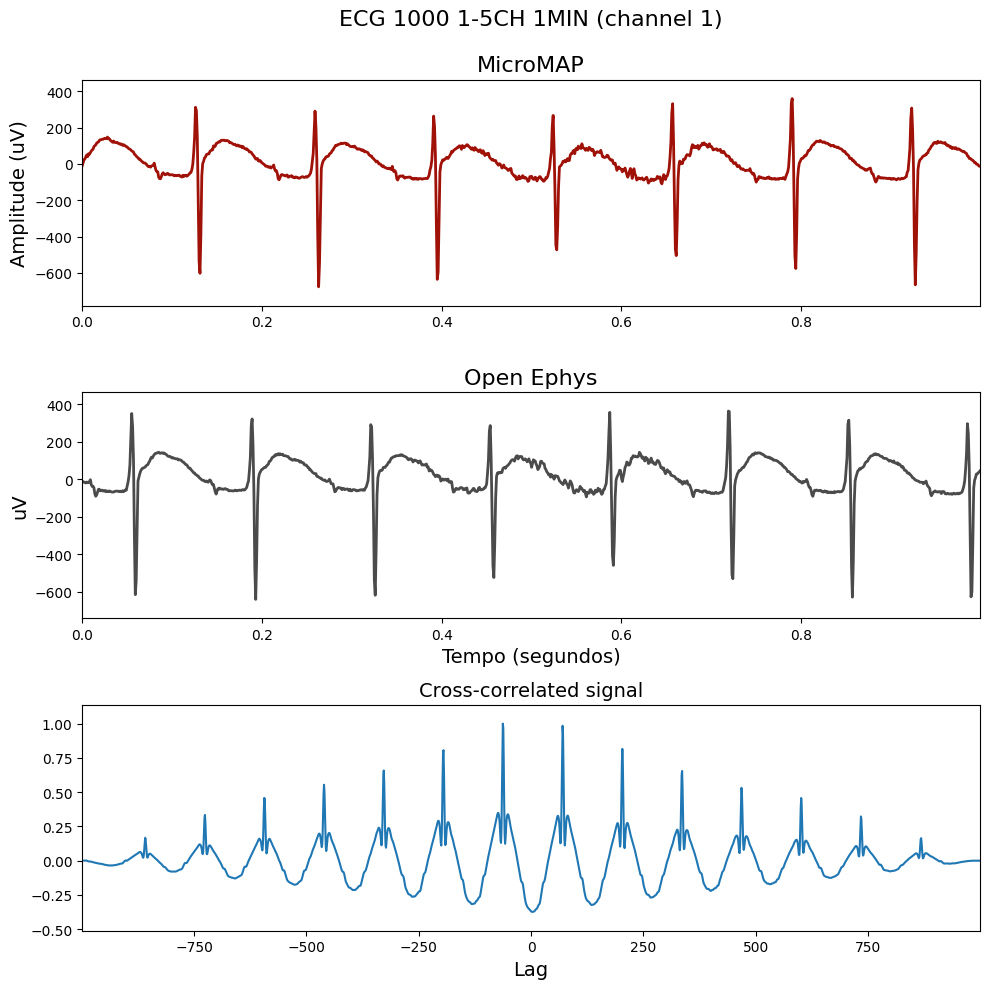

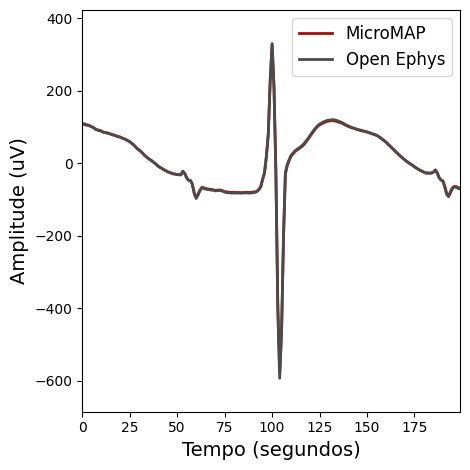

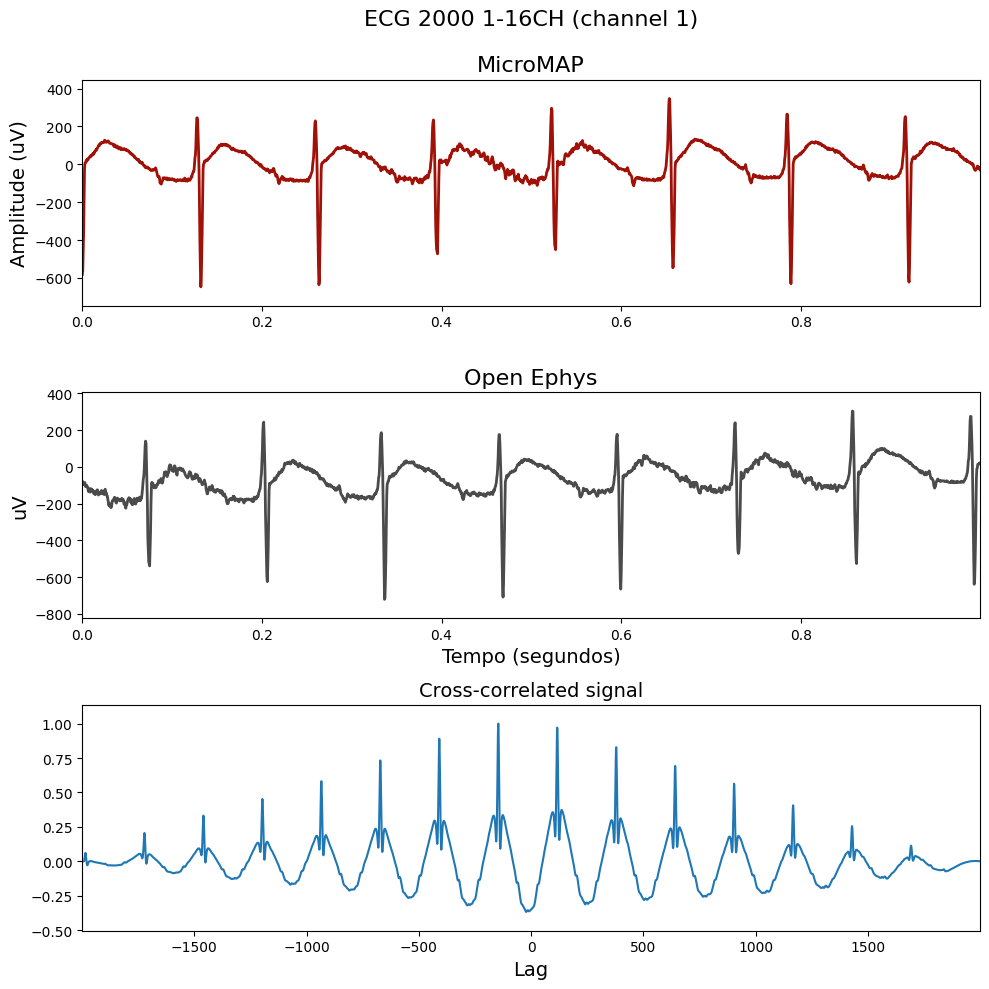

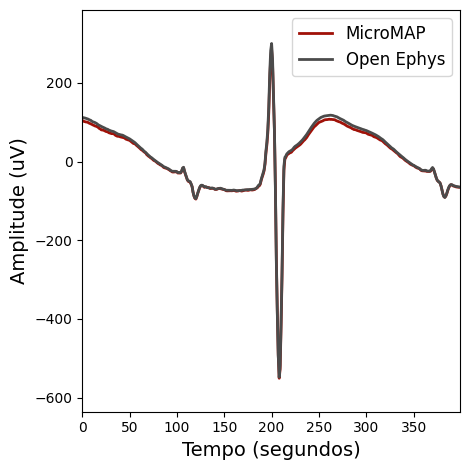

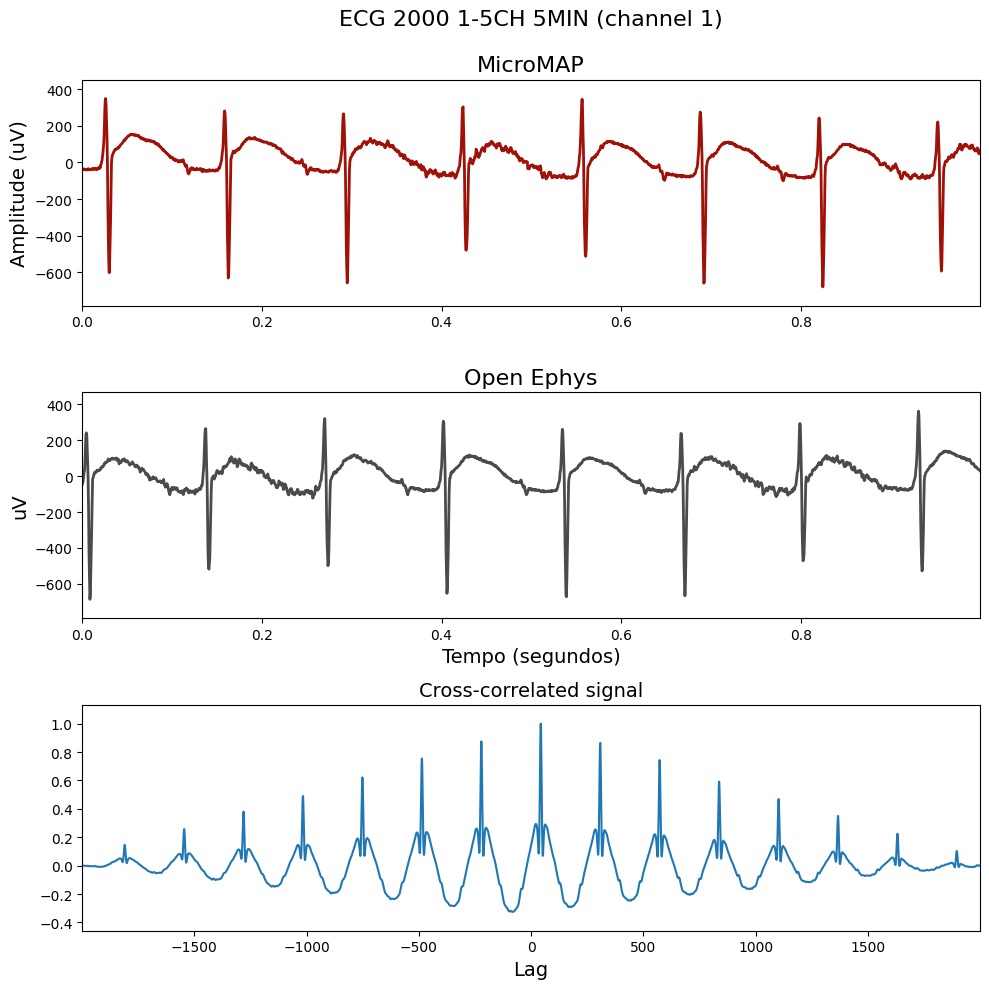

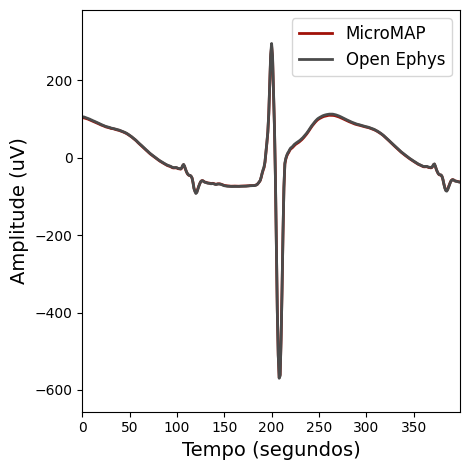

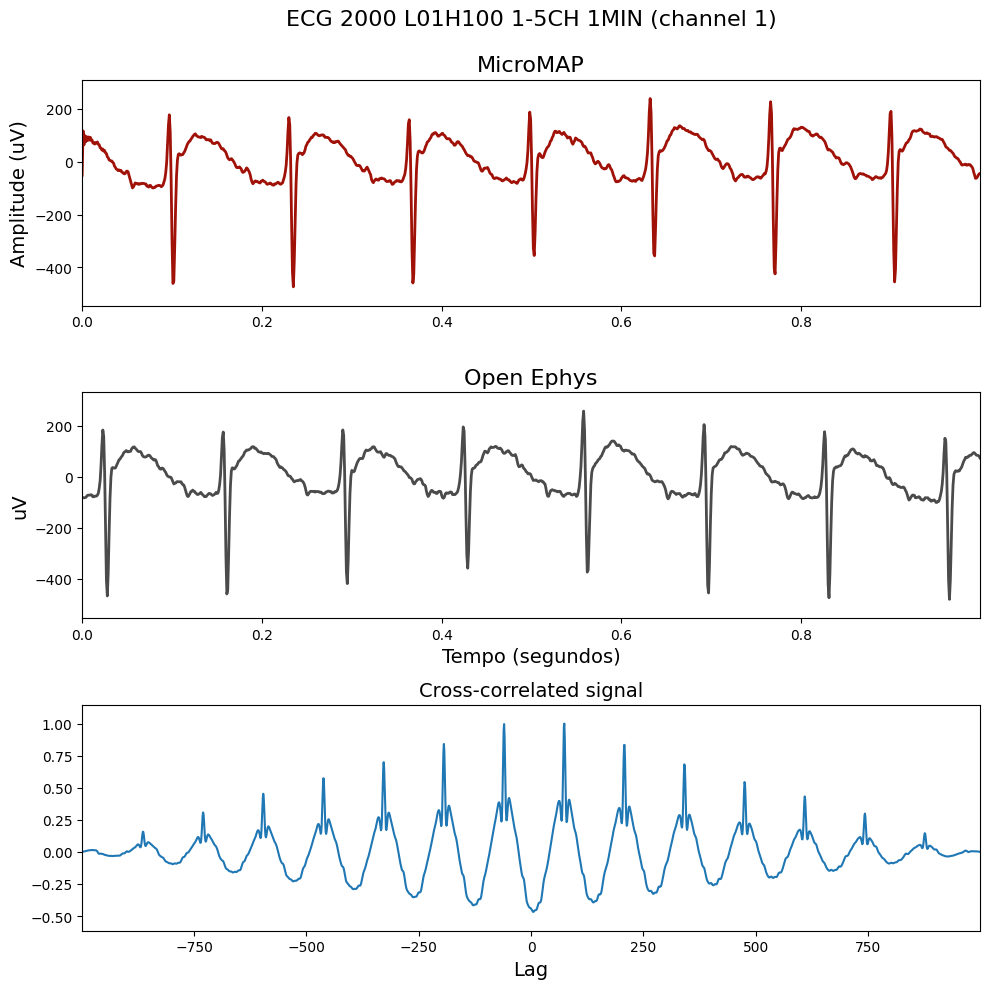

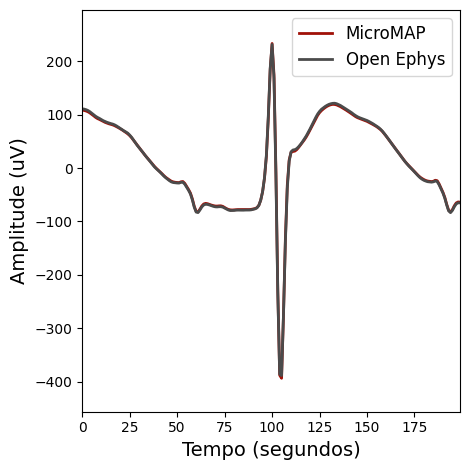

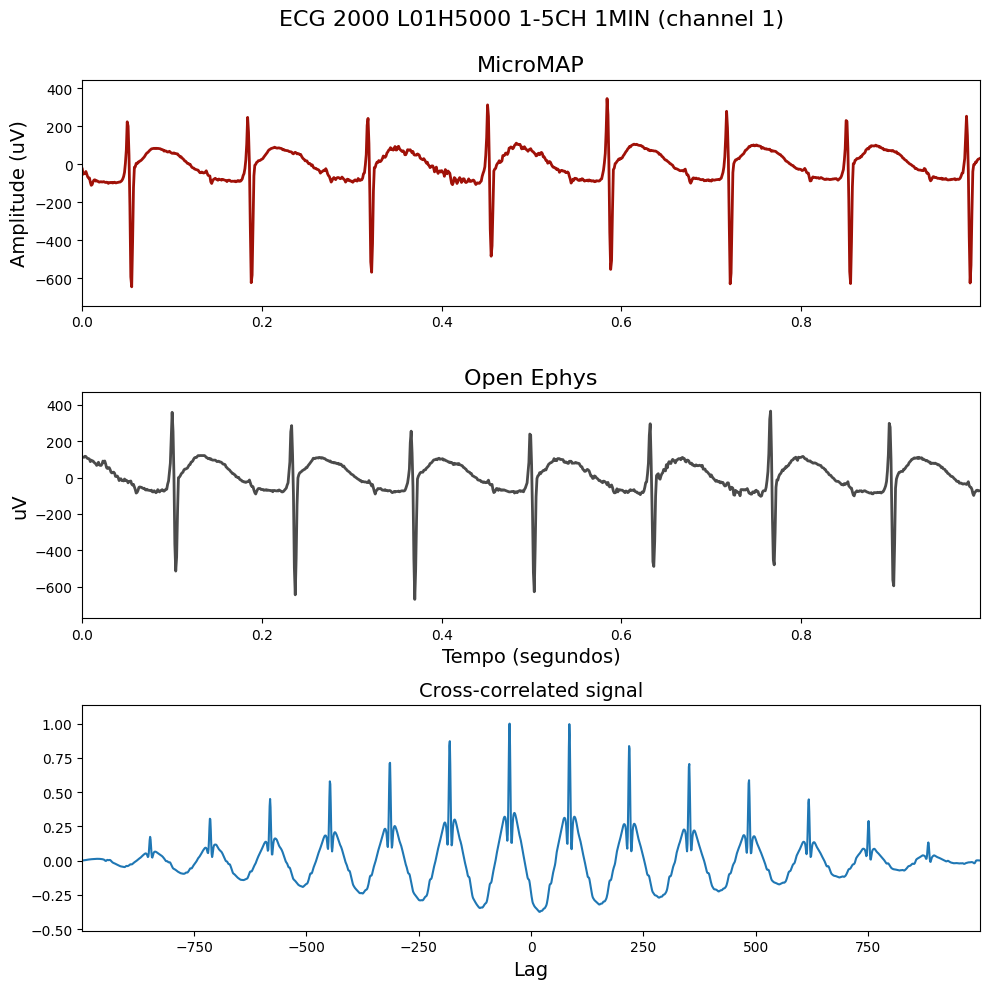

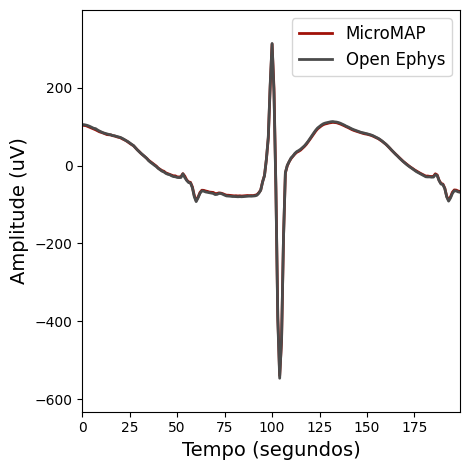

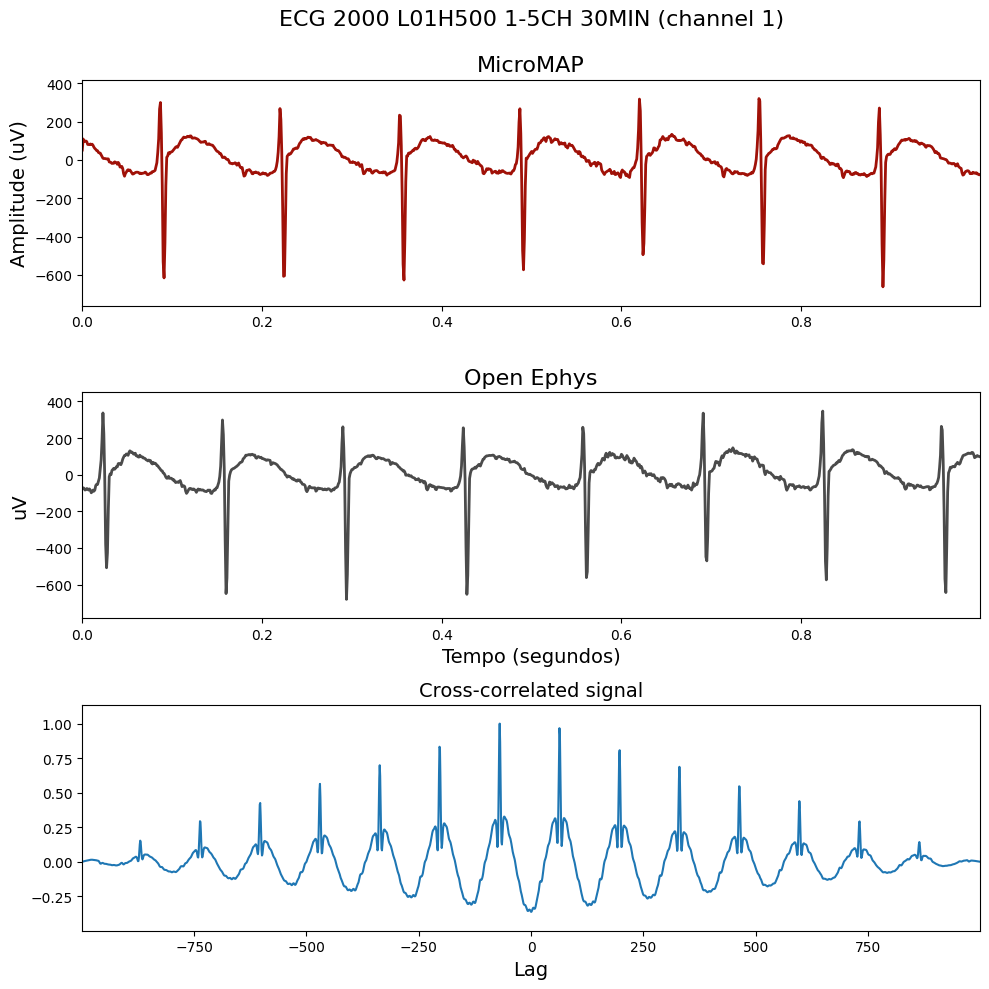

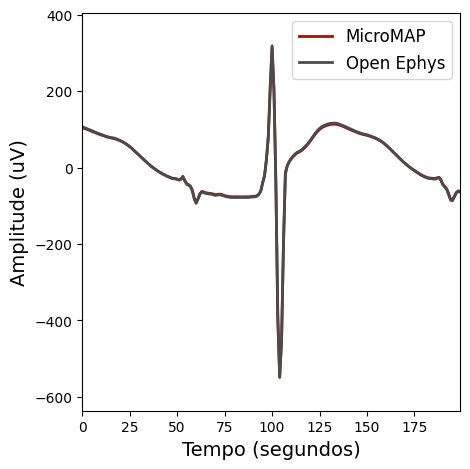

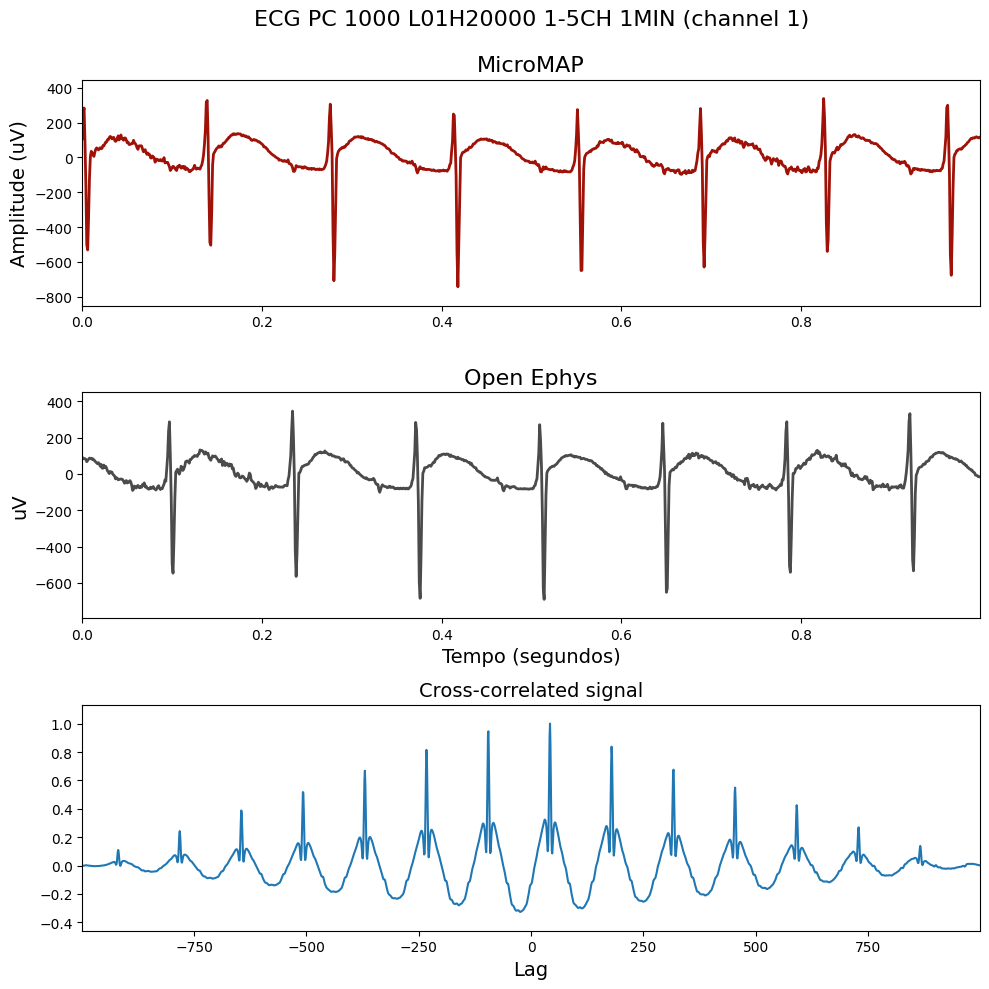

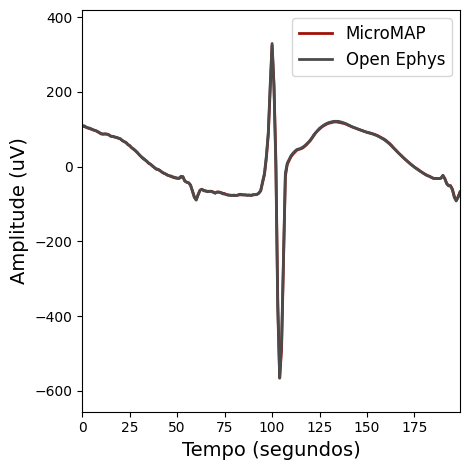

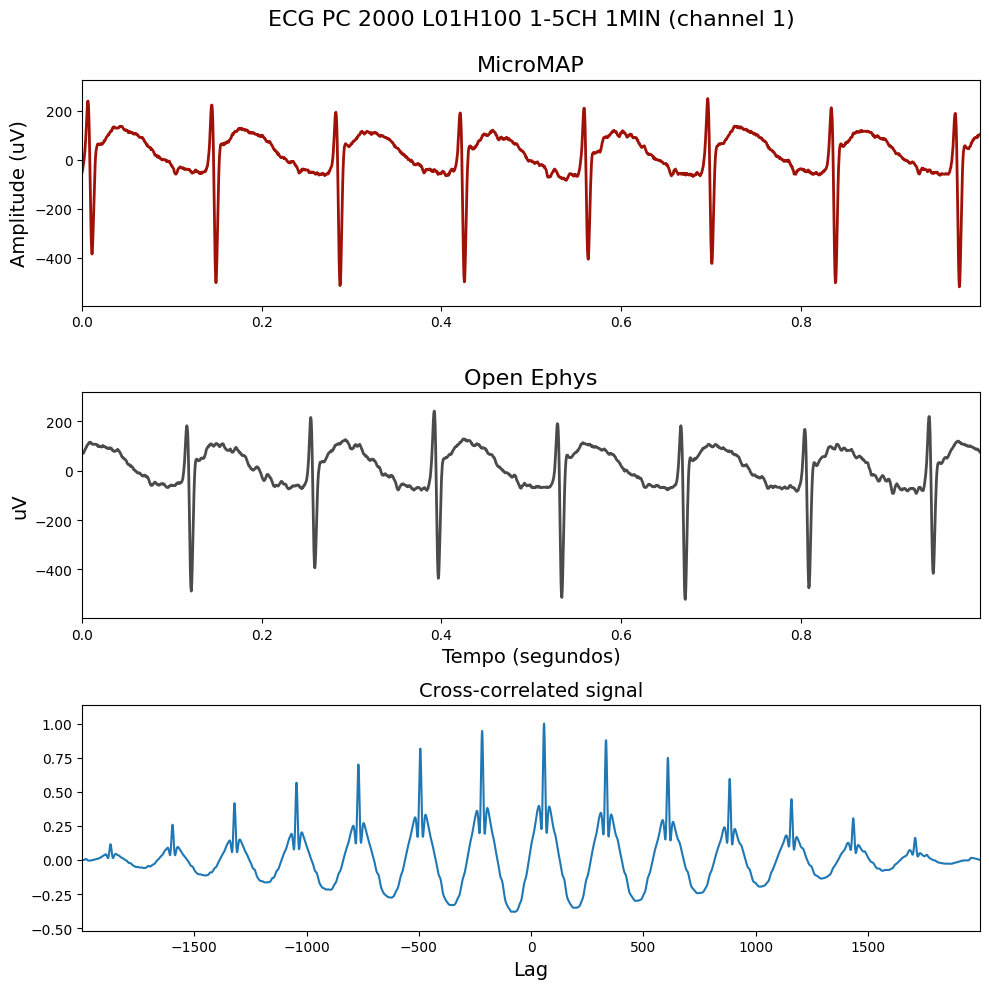

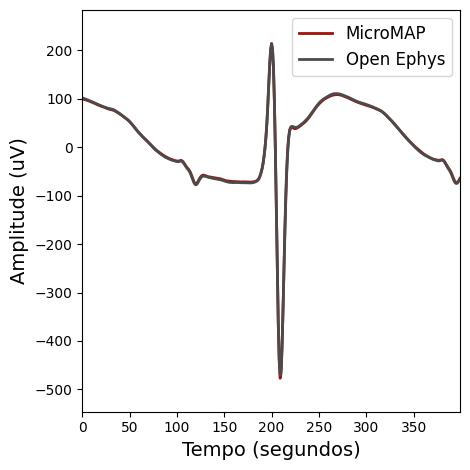

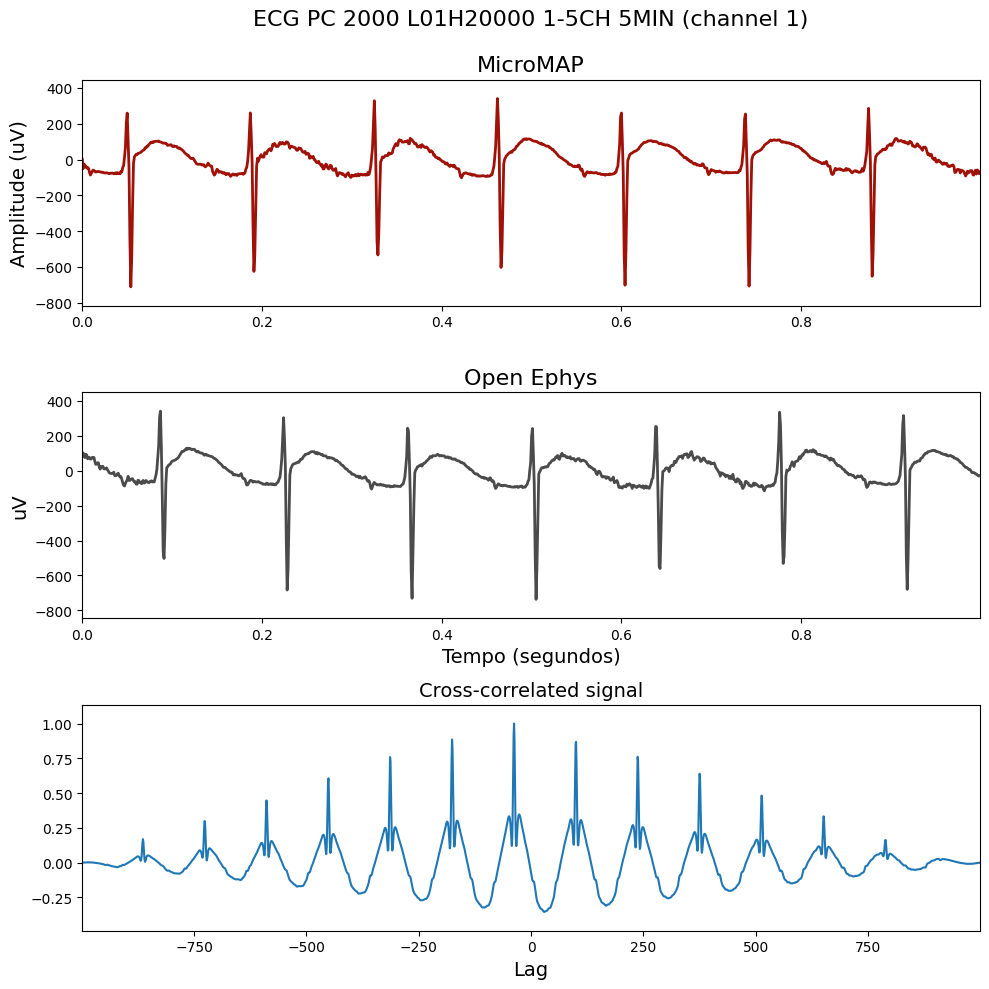

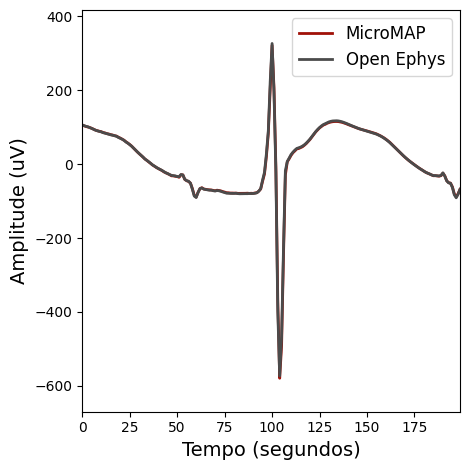

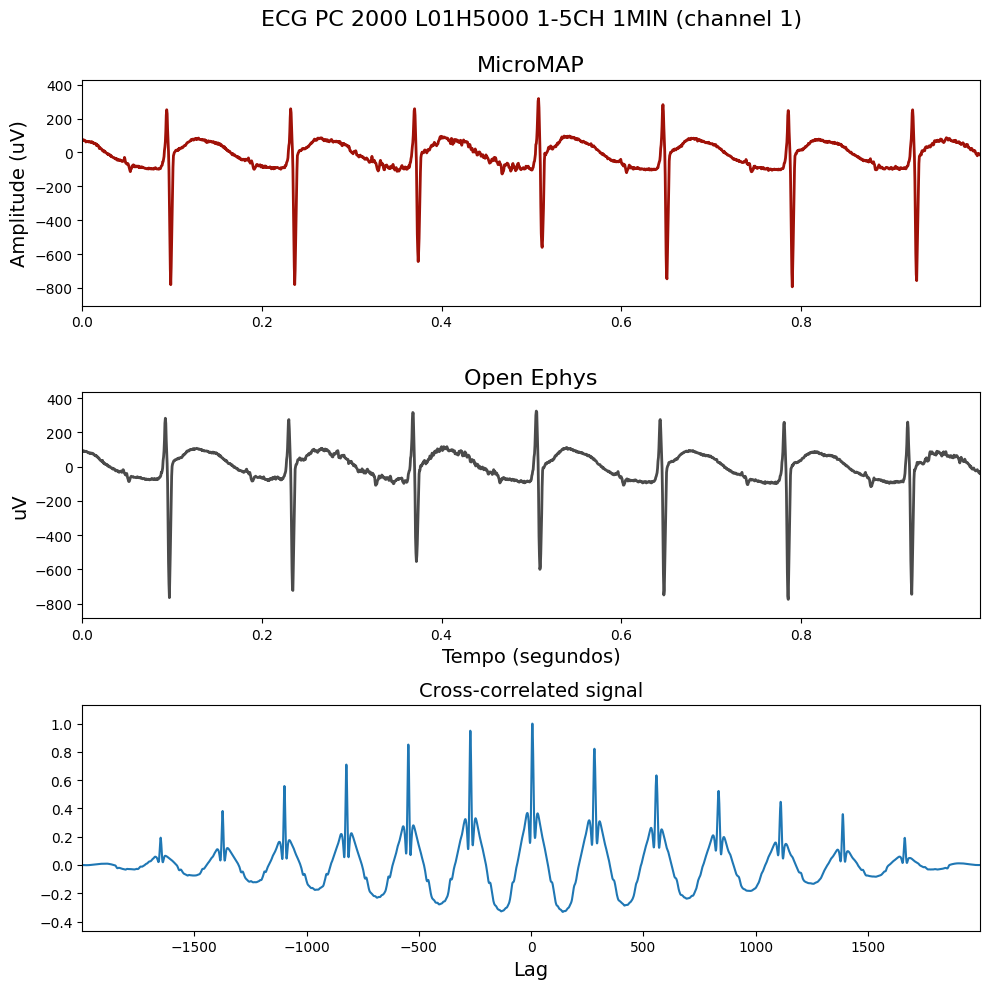

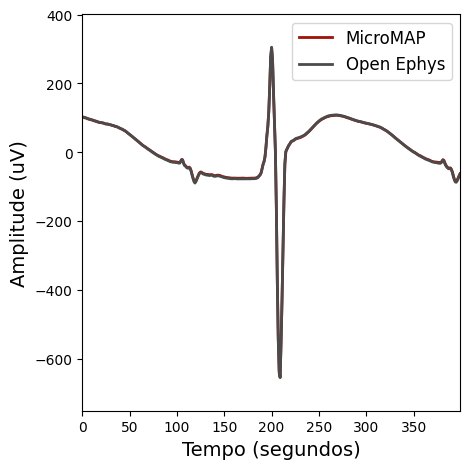

In [48]:
ok_data = [0,1,2,4,5,6,8,9,10,11]           # Recordings files that are getted from both DAQs
no_signal = [3,12]                          # Recordings files that are getted only from one DAQ (3 only from NNC and 12 only from Open Ephys)
different_peak = [7]                        # Recordings files that are getted from both DAQs but the QRS peaks are different

signal_correlation = []

root = tk.Tk()
root.attributes('-topmost',True)
root.iconify()

figures_folder = filedialog.askdirectory(title = "Select the folder to save figures")
root.destroy()

validation = {}
for n in ok_data:
    validation[n] = {}
    
    validation[n]['open_ephys'] = read_openephys(files_openephys, n)

    #open_ephys.bandpass_filter(0.1, 50)
    validation[n]['num_channels'] = validation[n]['open_ephys'].channels
    validation[n]['sample_frequency'] = validation[n]['open_ephys'].rate

    if n <= 7:
        validation[n]['nnc'] = read_nnc(files_rpi, n, validation[n]['num_channels'], validation[n]['sample_frequency'])
        #nnc.bandpass_filter(0.1, 50)
        if n >= 4:
            validation[n]['nnc'].rate = 2000
            validation[n]['nnc'].resample(1000)
        experiment_name = files_rpi[n].rsplit('/', 1)[1].rsplit('.', 1)[0]
        experiment_name = experiment_name.replace('_', ' ')
        experiment_name = experiment_name.upper()
    else:
        validation[n]['nnc'] = read_nnc(files_pc, n - 8, validation[n]['num_channels'], validation[n]['sample_frequency'])
        #nnc.bandpass_filter(0.1, 50)
        if n == 10 or n == 12:
            validation[n]['nnc'].rate = 2000
            validation[n]['nnc'].resample(1000)
        experiment_name = files_pc[n - 8].rsplit('/', 1)[1].rsplit('.', 1)[0]
        experiment_name = experiment_name.replace('_', ' ')
        experiment_name = experiment_name.upper()

    validation[n]['experiment_name'] = experiment_name
    validation[n]['comparision'] = analysis(validation[n]['nnc'], validation[n]['open_ephys'], validation[n]['experiment_name'])
    #validation[n]['comparision'].plot_all()
    validation[n]['comparision'].correlaction(0, int(validation[n]['nnc'].rate), figures_folder = figures_folder)
    validation[n]['comparision'].average_window(validation[n]['nnc'].rate, plot = True, figures_folder = figures_folder)

    validation[n]['pearson'] = validation[n]['comparision'].person_correlation()
    signal_correlation.append(validation[n]['pearson'])

In [51]:
print(signal_correlation)
print('Mean correlaction: ' + str(numpy.mean(signal_correlation)))
print('Standard deviation: ' + str(numpy.std(signal_correlation)))

[0.9997999609669598, 0.9995474973348628, 0.9999641110930865, 0.9998279270617374, 0.9998370493442983, 0.999720379097373, 0.9992548634279473, 0.9998246262223488, 0.9992367739546891, 0.9999468438851641]
Mean correlaction: 0.9996960032388467
Standard deviation: 0.0002505186391396288
